_version log: adding the angle measurements for boardband_

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from scipy import signal, interpolate
plt.rcParams.update({'font.size':14})

pixel_pitch = 9.9 #um

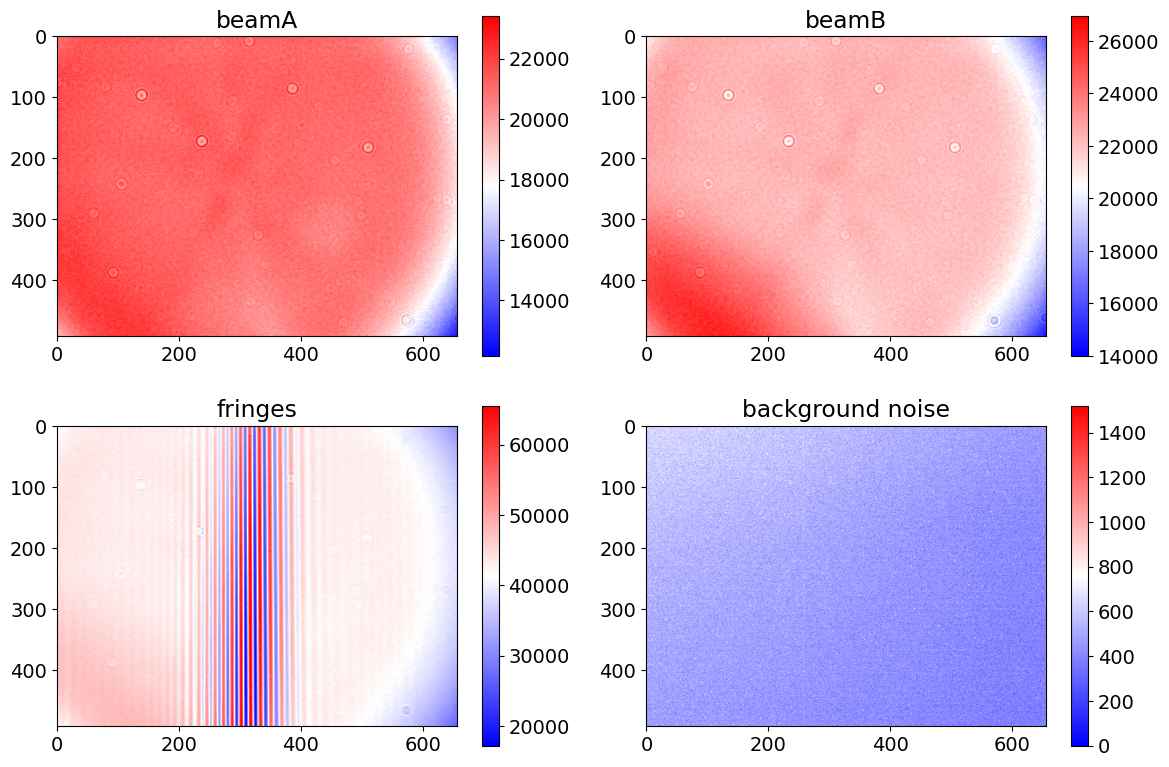

In [22]:
def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

fringes, beamA, beamB, background = import_standard_tif("ir", "9")

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

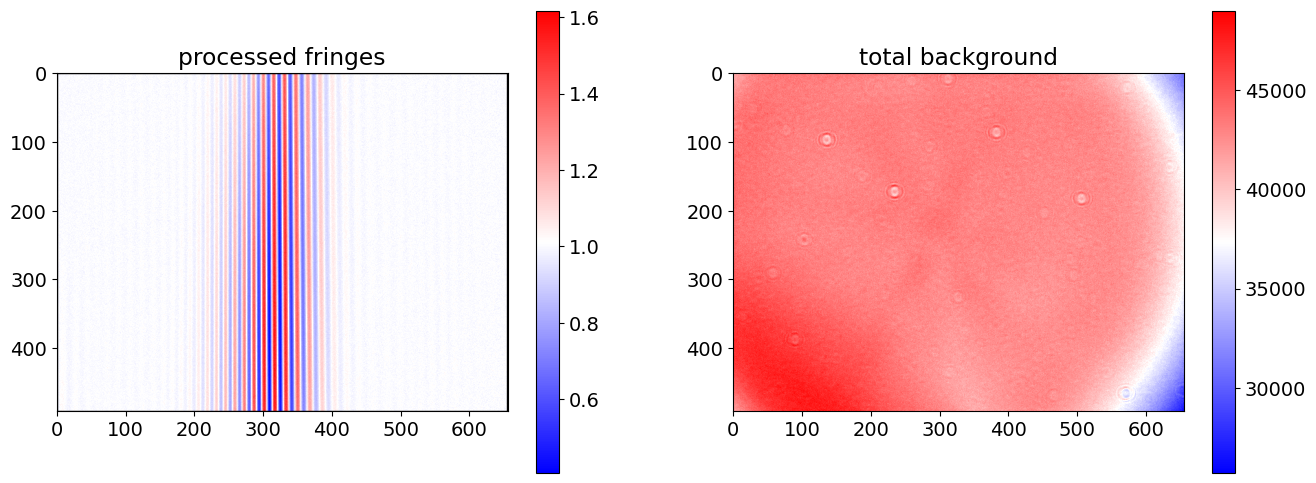

In [23]:
ROI = [[0,491],[0,655]] #region of interest in rows, columns. [[0,491],[0,655]]

def process_fringes(fringes, beamA, beamB, background):
    nofringes = beamA +beamB -background

    if False: #toggle which meathod you want to use. IDK which one is better.
        beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
    else:
        beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors and exaggerates the noise.
        beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                                posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                                neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                                nan= 0) #occors for 0/0
        
    return beamPost, nofringes

beamPost, nofringes = process_fringes(fringes, beamA, beamB, background)

plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

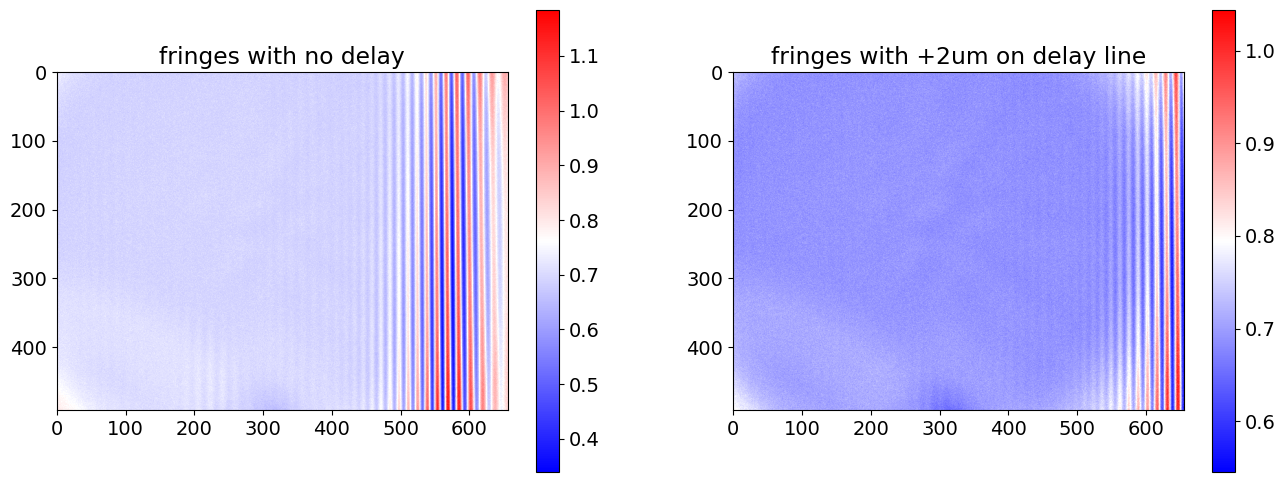

In [24]:
im = Image.open('data\\ir_fringes7_8.tif')
angle1 = np.array(im, dtype= np.float32)
im = Image.open('data\\ir_fringes7_9.tif')
angle2 = np.array(im, dtype= np.float32)

angle1post, nofringes = process_fringes(angle1, beamA, beamB, background)
angle2post, nofringes = process_fringes(angle2, beamA, beamB, background)

plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(angle1post, cmap='bwr')
plt.colorbar(im)
plt.title("fringes with no delay")

plt.subplot(1,2,2)
im=plt.imshow(angle2post, cmap='bwr')
plt.colorbar(im)
plt.title("fringes with +2um on delay line")

plt.show()

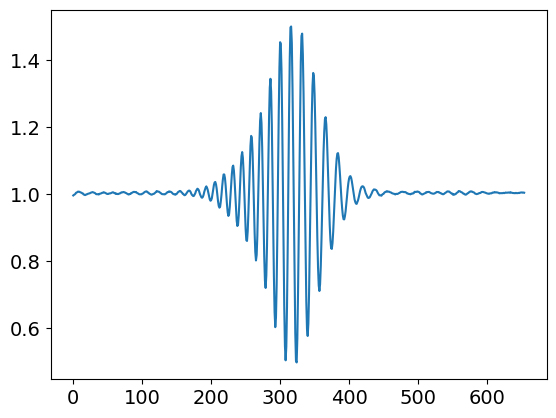

In [25]:
average_signal = np.mean(beamPost[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)

plt.plot(average_signal)
plt.show()


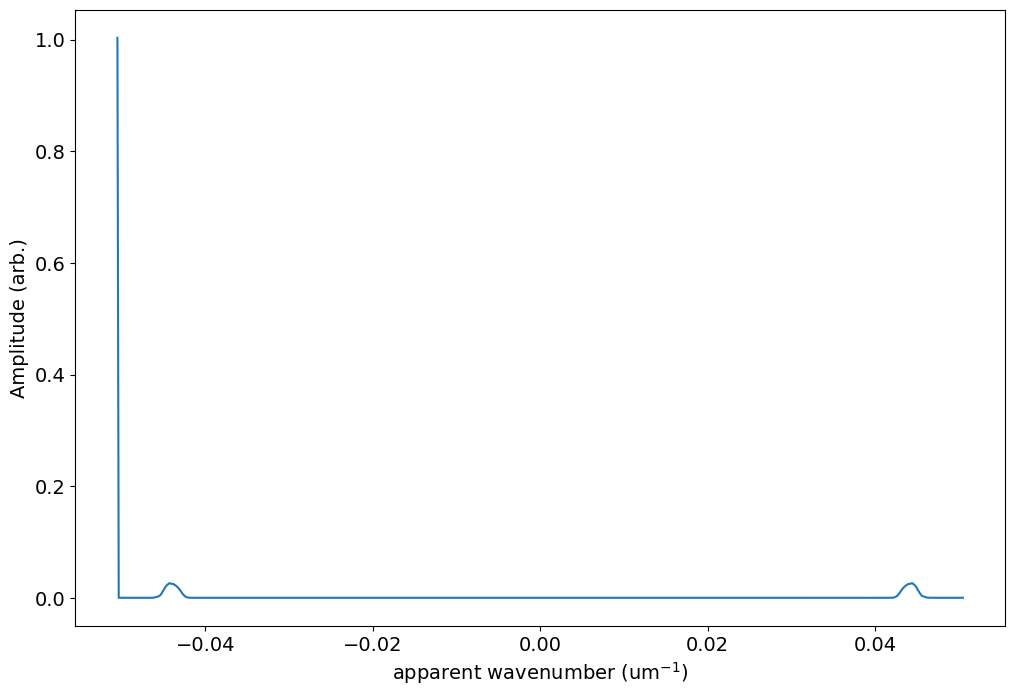

In [26]:
FT = np.fft.fft(average_signal, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.linspace(-1/2/pixel_pitch, 0, num_of_freqs) #niquist frequency = 1/2 * 1/pixel_pitch
freqs = np.concatenate((freqs, -freqs[-2::-1]))
freqs = freqs[:len(FT)]

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(freqs,
        abs(FT))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_13536\963838433.py:18: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +1]


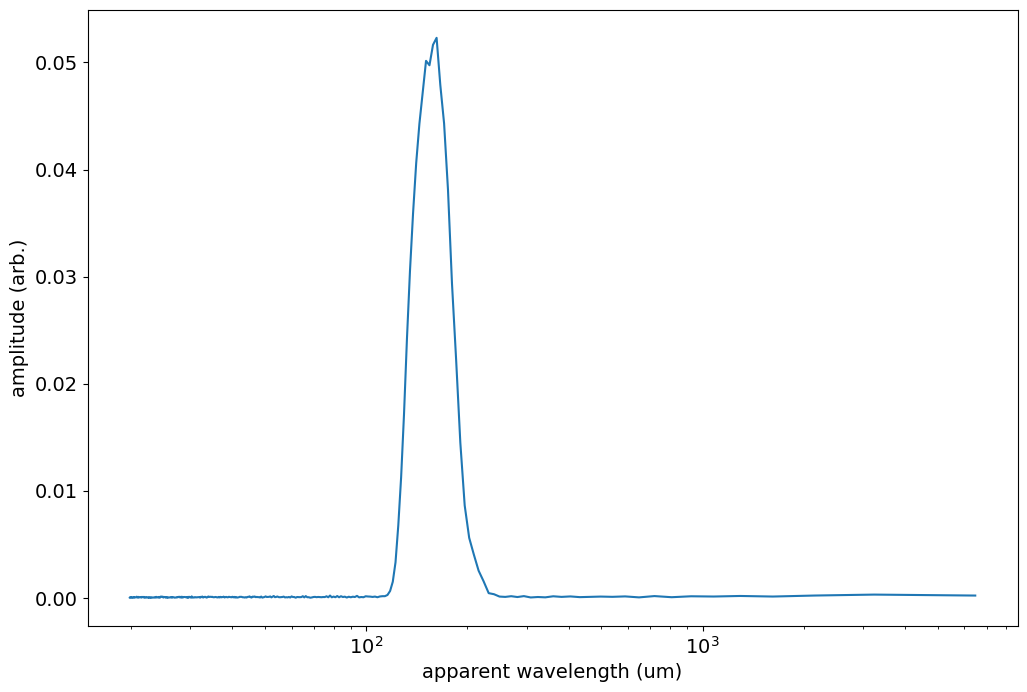

In [27]:
#FT = np.fft.fftshift(FT) #rearranges the array such that 0,0 at the beginning

#assign amplitudes from fft coeffients. Check how elin does this. (She is smarter than me!)
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])

if (samples//2 == samples/2): #if even
        amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))

        wavelengths = -1/freqs[:-num_of_freqs +2]

else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))

        wavelengths = -1/freqs[:-num_of_freqs +1]

amplitude = amplitude[::-1] #the largest wavelength is the smallest frequency so the order needs to be reversed

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[:-1])
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [32]:
################COMPENSATE FOR ANGLE#################

angle_between_beams = 0.272 # =2*theta. in degrees. Has a large uncertainty

theta = angle_between_beams/2 *np.pi/180 #in radians
corrected_wavelengths = wavelengths *2*np.sin(theta)

###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

def import_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    return array

source = import_csv("SLS201L_spectrum.csv", 1)
source[:,1] = source[:,1] / np.max(source[:,1]) #normalise
source_function = interpolate.interp1d(source[:,0], source[:,1], fill_value= 0, bounds_error= False) #0 intensity seems like good assumtion here. Also try fill_value= np.nan
source[:,1] /= np.nanmax(source[:,1]) #normalise

camera = import_csv("mantra_spectrum.csv", 0)
camera[:,1] = camera[:,1] / np.max(camera[:,1]) #normalise
camera_function = interpolate.interp1d(camera[:,0], camera[:,1], fill_value= 0, bounds_error= False) #0 intensity is a good assumtion for longer wavelengths
camera[:,1] /= np.nanmax(camera[:,1]) #normalise

mirror = import_csv("unprotected_gold_mirror_spectrum.csv", 1)
mirror[:,0] *= 1e3 #convert to nm
mirror[:,1] = mirror[:,1] / np.max(mirror[:,1]) #normalise
mirror_function = interpolate.interp1d(mirror[:,0], mirror[:,1], fill_value= 0, bounds_error= False) #an extrapolation seems the most appropitate here
mirror[:,1] /= np.nanmax(mirror[:,1]) #normalise

def manufacturers_function(x):
    return mirror_function(x) *source_function(x) *camera_function(x)
manufacturers = manufacturers_function(corrected_wavelengths[:-1] *1e3)

amplitude2 = amplitude[:-1] /np.nanmax(amplitude[:-1]) #normalise
percentagediff = (manufacturers_function(corrected_wavelengths[:-1] *1e3) - amplitude2) /amplitude2
amplitude2 *= np.nanmin(percentagediff[percentagediff != -1]) +1

normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1] *1e3) #factor in the camera sensitivity
normalised_amplitude /= np.nanmax(normalised_amplitude[np.isfinite(normalised_amplitude)]) #normalise
percentagediff = (mirror_function(corrected_wavelengths[:-1] *1e3) *source_function(corrected_wavelengths[:-1] *1e3) - normalised_amplitude) /normalised_amplitude
normalised_amplitude *= np.nanmin(percentagediff[percentagediff != -1]) +1 #re-scale

C:\Users\syf83691\AppData\Local\Temp\ipykernel_13536\4062505763.py:40: RuntimeWarning: divide by zero encountered in divide
  normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1] *1e3) #factor in the camera sensitivity
C:\Users\syf83691\AppData\Local\Temp\ipykernel_13536\4062505763.py:42: RuntimeWarning: invalid value encountered in divide
  percentagediff = (mirror_function(corrected_wavelengths[:-1] *1e3) *source_function(corrected_wavelengths[:-1] *1e3) - normalised_amplitude) /normalised_amplitude


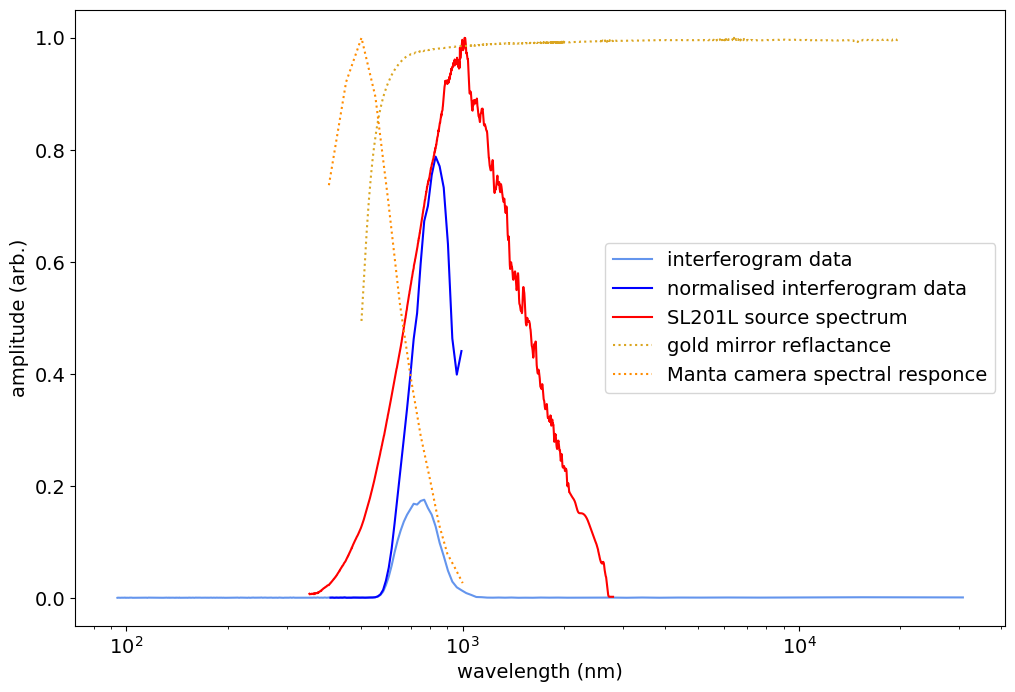

In [33]:
plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        amplitude2, #rescale to fit
        label = "interferogram data",
        color = "cornflowerblue")
plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        normalised_amplitude,
        label = "normalised interferogram data",
        color = "blue")
plt.plot(source[:,0],
        source[:,1],
        label = "SL201L source spectrum",
        color = "red")
plt.plot(mirror[:,0],
        mirror[:,1],
        label = "gold mirror reflactance",
        color = "goldenrod",
        linestyle = ":")
plt.plot(camera[:,0],
        camera[:,1],
        label = "Manta camera spectral responce",
        color = "darkorange",
        linestyle = ":")
plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log") 
plt.legend()
plt.show()

In [30]:
#################FINDING LARGEST AMPLITUDES############

df = np.stack([amplitude,
                corrected_wavelengths])
df = np.transpose(df)

df = pd.DataFrame(df, columns = ["amplitude","wavelength"])
df.sort_values("amplitude", ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(10) #show the top 10 wavelengths

,amplitude,wavelength
0,1.003338,-inf
1,0.052302,1.539661
2,0.051646,1.502109
3,0.050152,1.432243
4,0.049739,1.466344
5,0.047904,1.579140
6,0.047148,1.399692
7,0.044307,1.620696
8,0.044275,1.368588
9,0.040609,1.338836


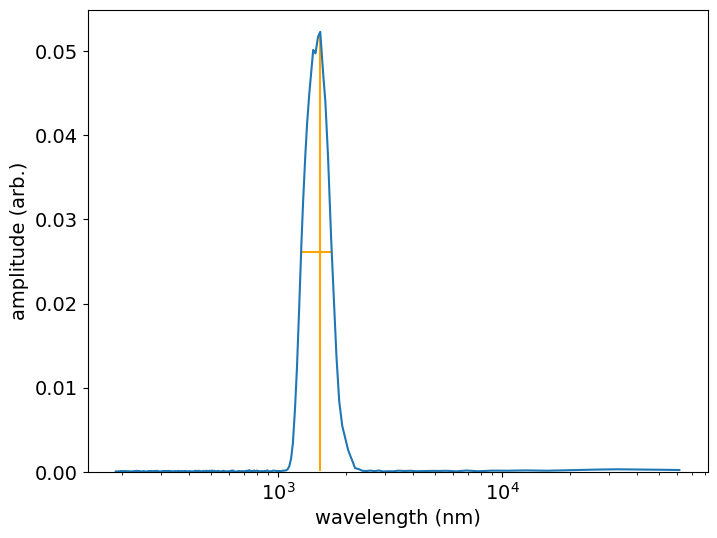

[1539.71023394]
[656.20956506]


In [31]:
################FINDING PEAKS AND FWHM#####################

n = 100_000 #how many liniarlly spaced points to plot. It has to be liniar in order to be able to convert from indexes to um
relative_prominence = 1e-1 #this should be at least 1 / the S:N ratio.

spectrum_function = interpolate.interp1d(corrected_wavelengths[:-1], amplitude[:-1])
x = np.linspace(corrected_wavelengths[0], corrected_wavelengths[-2], n)
y = spectrum_function(x)

peaks, peak_properties = signal.find_peaks(y, prominence = relative_prominence*y.max()) #prominence = the smallest peak that can be considered a signal rather than noise. It would be nice to calculate this.
FWHM = signal.peak_widths(y, peaks, rel_height=0.5) #gives the FWHM in terms of indexes
FWHM = np.vstack(FWHM)

peaks = peaks * (corrected_wavelengths[-2] - corrected_wavelengths[0]) /n + corrected_wavelengths[0] #convert to um
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1] * (corrected_wavelengths[-2] - corrected_wavelengths[0]) /n + corrected_wavelengths[0] #convert to um.
FWHM[np.arange(len(FWHM))!=1] = FWHM[np.arange(len(FWHM))!=1]*1e3 #convert to nm. FWHM[np.arange(len(FWHM))!=1] will exclude index 1 (height of FWHM)

plt.figure(figsize = (8,6))
plt.subplot(1, 1, 1)

plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
#plt.xscale("log")
plt.hlines(*FWHM[1:,:], color = "orange")
plt.vlines(x= peaks*1e3,
           ymin= spectrum_function(peaks) - peak_properties["prominences"],
           ymax= spectrum_function(peaks), 
           color= "orange")
plt.plot(x *1e3,
        y)

#plt.xlim(3e2, 8e2)
plt.xscale("log")
plt.ylim(0)

plt.show()

print(peaks*1e3) # in nm
print(FWHM[0])